In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

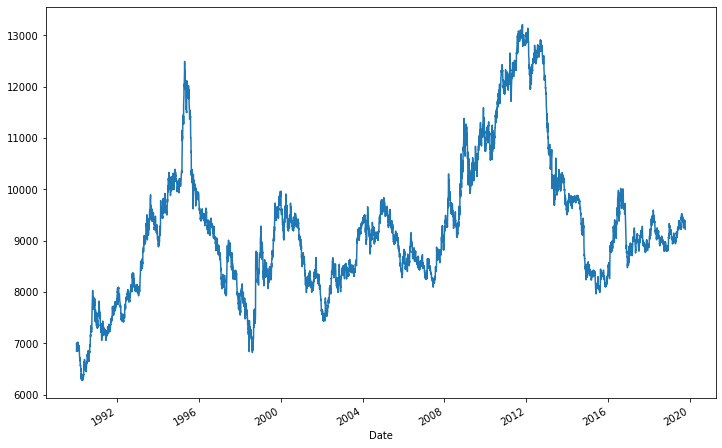

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures["Settle"].plot(figsize = (12, 8))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_futures_noise, yen_futures_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_decomposition = yen_futures["Settle"].to_frame()
yen_decomposition["Noise"] = yen_futures_noise
yen_decomposition["Trend"] = yen_futures_trend
yen_decomposition.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:xlabel='Date'>

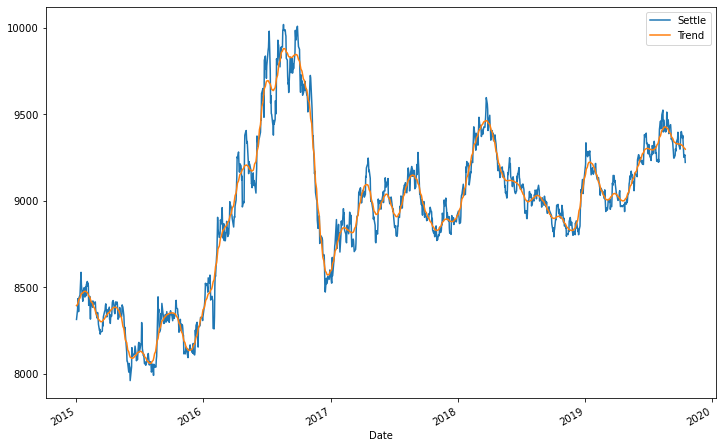

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_decomposition[['Settle', 'Trend']]['2015-01-01': ].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

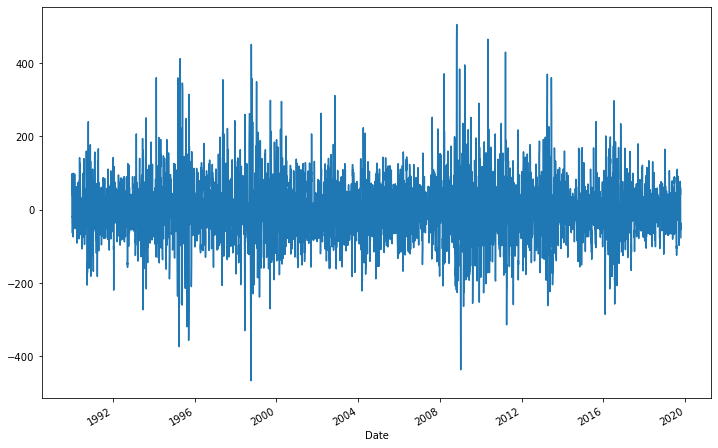

In [9]:
# Plot the Settle Noise
yen_futures_noise.plot(figsize=(12,8))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [11]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
from statsmodels.tsa.arima_model import ARMA
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

/Applications/anaconda3/envs/pyvizenv2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [12]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 28 Sep 2021   AIC                          15798.142
Time:                        15:10:42   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3349           +0.0000j            3.3349            0.5000
AR.2         -157.1502           +0.0000j          157.1502            0.5000
MA.1           -3.3938           +0.0000j            3.3938            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Futures 5 Day Returns Forcast'}>

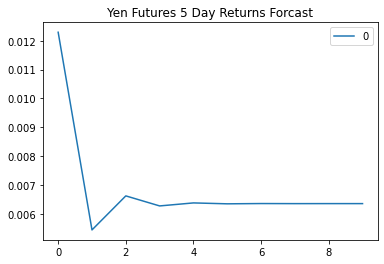

In [13]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=10)[0]).plot(title='Yen Futures 5 Day Returns Forcast')

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures["Settle"].values, order=(5, 1, 1))

# Fit the model
results = model.fit()

/Applications/anaconda3/envs/pyvizenv2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Applications/anaconda3/envs/pyvizenv2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.ari

In [15]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 28 Sep 2021   AIC                          83905.238
Time:                        15:12:26   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.y      0.2826      0.699      0.404      0.686      -1.087       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.031      0.302      -0.037       0.011
ar.L4.D.y     -0.0136      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2977      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8923           -1.3782j            2.3410           -0.1002
AR.2            1.8923           +1.3782j            2.3410            0.1002
AR.3           -2.2722           -3.0195j            3.7789           -0.3527
AR.4           -2.2722           +3.0195j            3.7789            0.3527
AR.5          -11.1426           -0.0000j           11.1426           -0.5000
MA.1            3.3596           +0.0000j            3.3596            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Futures 5 Day Price Forecast'}>

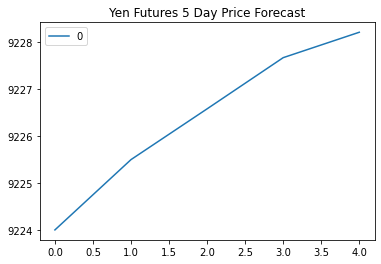

In [16]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='Yen Futures 5 Day Price Forecast')

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [22]:
import arch
from arch import arch_model

In [23]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)


# Fit the model
results = model.fit(disp="off")

In [24]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Tue, Sep 28 2021   Df Residuals:                     7514
Time:                        15:24:52   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.708e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.622      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [25]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [27]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

/Applications/anaconda3/envs/pyvizenv2/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [28]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434029,7.475725,7.516846,7.557404,7.597412


In [29]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434029
h.2,7.475725
h.3,7.516846
h.4,7.557404
h.5,7.597412


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

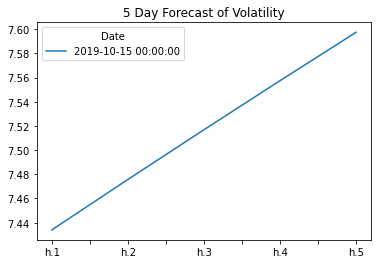

In [30]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Based on the analyis this is not a time to buy, because returns are forecast to decrease and volatility is forcast to increase. Based on the model evaluation I low confidence in using these models for trading because the p-values are greather than 0.05.